<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/main/GridWorldSequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Part 1 Behaviour, environments and optimization: evolution and learning**

###**Animals have evolved in an environment, their behaviour is only meaningful within this environment.**

###Objectives: Introduce the core concepts of 
* ### **environment**, where an organism lives;
* ### **behaviour**, what the organism does there; 
* ### **optimization**, how learning and evolution shape behaviour so that the organism's behaviour is better suited to its environment.


___
# Chapter 1.1 An optimization based view on the world

### Objectives: Develop examples of how behaviour is described and evaluated relative to being [good](## "This is a very loaded term, to be unpacked carefully later") in an environmental niche. 

You will learn:
*   What is a policy? A formalization of behaviour as a function that determines an organism's actions (usually) based on the organism's experience of their environment.
*   What is a good policy? Rewards (and other signals?) from the environment in response to the organisms behaviour are integrated into a Loss/Objective function to evaluatate (and sometimes improve) a policy.
*   What is stochasticity? The environment and an organism's behavior may have elements of randomness. This can make policy evaluation challenging; was the policy generating bad behaviour or was the organism just unlucky? 



___
# **Sequence 1.1.1: Gridworld Introduction**

### Objective:

Create a simple environment-organism system to illustrate how an organism's **behaviour** within an **environment** can be evaluated using **Rewards**. Within this context we will see how behavior guided by intellegence can be better and how **randomness** can make evalutation of behaviour difficult


# Setup



In [1]:
import ipywidgets as widgets
import threading
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import time
import asyncio
#import jax

!pip3 install vibecheck datatops > /dev/null 2> /dev/null #google.colab
from vibecheck import DatatopsContentReviewContainer

#from google.colab import output as colab_output
#colab_output.enable_custom_widget_manager()

In [2]:
# @title Plotting Functions
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**

def makeGrid(xSize, ySize):
  """Plots an xSize by ySize grid with cells centered on integer indices and 
  returns fig and ax handles for futher use
  Args:
    xSize (int): size of grid in x dimension
    ySize (int): size of grid in y dimension

  Returns:
    fig (matplotlib.figure.Figure): figure handle for the grid
    ax: (matplotlib.axes._axes.Axes): axes handle for the grid
  """
  fig, ax = plt.subplots(figsize = (7,6), layout='constrained')
  #ax.axis("equal")
  ax.set_xticks(np.arange(0, xSize, 1))
  ax.set_yticks(np.arange(0, ySize, 1))
  # Labels for major ticks
  ax.set_xticklabels(np.arange(0, xSize, 1),fontsize=8)
  ax.set_yticklabels(np.arange(0, ySize, 1),fontsize=8)

  # Minor ticks
  ax.set_xticks(np.arange(0.5, xSize-0.5, 1), minor=True)
  ax.set_yticks(np.arange(0.5, ySize-0.5, 1), minor=True)

  # Gridlines based on minor ticks
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)

  # Remove minor ticks
  ax.tick_params(which='minor', bottom=False, left=False)

  ax.set_xlim(( -0.5, xSize-0.5))
  ax.set_ylim(( -0.5, ySize-0.5))
  return fig, ax

def plotFood(fig, ax, xyFoodLoc):
  food = ax.scatter([], [], s=150, marker='o', color='red', label='Food')
  food.set_offsets(xyFoodLoc)
  return food

def plotCritter(fig, ax, xyCritterLoc):
  critter = ax.scatter([], [], s=250, marker='h', color='blue', label='Critter')
  critter.set_offsets(xyCritterLoc)
  return critter

In [3]:
# @title Simulation Functions, Variables and Widgets
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**

# keep track of all relevant states of the simluation in a global state dictionary
# maybe turn this into an object if we want to have multiple independent simulations going on?

def initLoc(xSize, ySize, num):
  """Returns random 2d grid locations, without replacement, 
  in both unravled/flat coordinates and as xy pairs"""
  intLoc = np.random.choice(xSize * ySize, num, replace=False)
  xyLoc = np.vstack(np.unravel_index(intLoc, (xSize, ySize))).T
  return intLoc, xyLoc

def initState(xSize=7,
              ySize=7,
              numFoods=10,
              xyCritter=None):
  state = {'numMoves': 0,
           'numEats': 0,
           'numFoods': numFoods,
           'xyFoodLoc': np.array([[]]),
           'intFoodLoc': np.array([]),
           'xSize': xSize,
           'ySize': ySize}

  #randomly initialize food locations
  if numFoods > xSize * ySize -1:
    state['numFoods'] = xSize * ySize -1
  state['intFoodLoc'], state['xyFoodLoc'] = initLoc(state['xSize'],state['ySize'],state['numFoods'])

  if xyCritter is None:
    # put critter roughly in the middle
    state['xyCritterLoc'] = np.array([[np.floor(state['xSize']/2), np.floor(state['ySize']/2)]], dtype=int)
    state['intCritterLoc'] = np.ravel_multi_index((state['xyCritterLoc'][:,0],state['xyCritterLoc'][:,1]), (state['xSize'], state['ySize']))
  else:
    state['xyCritterLoc'] = np.array(xyCritter).reshape((1,2))
    state['intCritterLoc'] = np.ravel_multi_index((state['xyCritterLoc'][:,0],state['xyCritterLoc'][:,1]), (state['xSize'], state['ySize']))
  return state

state = initState()

def updateCritterLocation(x, y):
  state['numMoves'] = state['numMoves'] + 1
  state['xyCritterLoc'] = np.array([[x,y]])
  state['intCritterLoc'] = np.ravel_multi_index((state['xyCritterLoc'][:,0],state['xyCritterLoc'][:,1]), (state['xSize'], state['ySize']))

def eating():
  # is the critter on a food patch
  if state['intCritterLoc'][0] in set(state['intFoodLoc']):
    #critter is on a food patch
    state['numEats'] = state['numEats'] + 1
    # figure out where the new food will go where there isn't already food
    newFoodLoc = np.random.choice(list(set(np.arange(state['xSize']*state['ySize'])) - set(state['intFoodLoc'])))
    #remove the eaten food
    newFoodLocSet = set(state['intFoodLoc'])
    newFoodLocSet.remove(state['intCritterLoc'][0])
    # add the new food
    newFoodLocSet.add(newFoodLoc)
    
    #update state
    state['intFoodLoc'] = np.array(np.sort(list(newFoodLocSet)))
    state['xyFoodLoc'] = np.vstack(np.unravel_index(state['intFoodLoc'], (state['xSize'], state['ySize']))).T
    state['eatingString'] = ('You ate the food here, new food at ' + str(np.unravel_index(newFoodLoc, (state['xSize'], state['ySize']))))
  else:
    state['eatingString'] = 'No food here'

def updateState(x, y):
  updateCritterLocation(x, y)
  eating()
  #print(stateDict['foodLocationsUnravel'])

output = widgets.Output()

def plotFigFromScratch():
  fig, ax = makeGrid(state['xSize'], state['ySize'])
  plotFood(fig, ax, state['xyFoodLoc'])
  plotCritter(fig, ax, state['xyCritterLoc'])
  fig.legend(loc = "outside right upper")
  plt.show()

upButton = widgets.Button(description="Up")
downButton = widgets.Button(description="Down")
leftButton = widgets.Button(description="Left")
rightButton = widgets.Button(description="Right")
randomMovement = widgets.Checkbox(
    value=False,
    description='Move Randomly',
    disabled=False,
    indent=False
)

def randomClick():
  move = np.random.randint(0,4)
  if move == 0:
    upButton.click()
  elif move == 1:
    downButton.click()
  elif move == 2:
    leftButton.click()
  elif move == 3:
    rightButton.click()
  else:
    print('should not happen')


class Timer:
  def __init__(self, timeout, callback):
    self._timeout = timeout
    self._callback = callback
  async def _job(self):
    await asyncio.sleep(self._timeout)
    self._callback()
  def start(self):
    self._task = asyncio.ensure_future(self._job())
  def cancel(self):
    self._task.cancel()

clickTimer = Timer(5.0, randomClick)

def buttonOutputUpdate(whichButton, x, y):
  with output:
    if randomMovement.value == True:
      if hasattr(clickTimer, '__Task'):
        clickTimer.cancel()
    output.clear_output(wait=True)
    print("Moved " + whichButton + ". " + "Criter is now at ({}, {}).".format(x,y))
    print(state['eatingString'])
    print("Moves: {0} \tFood Eaten: {1} \tFood Per Move: {2}".format(state['numMoves'], state['numEats'], state['numEats'] / state['numMoves']))
    plotFigFromScratch()
    if randomMovement.value == True:
      clickTimer.start()

def on_upButton_clicked(b):
  whichButton = 'up'
  x = state['xyCritterLoc'][0][0]
  y = state['xyCritterLoc'][0][1]
  if y >= state['ySize']-1:
    y = state['ySize'] - 2
  elif y < state['ySize']-1:
    y = y+1
  updateState(x, y)
  buttonOutputUpdate(whichButton, x, y)

def on_downButton_clicked(b):
  whichButton = 'down'
  x = state['xyCritterLoc'][0][0]
  y = state['xyCritterLoc'][0][1]
  if y > 0 :
    y = y-1
  elif y <= 0:
    y = 1
  updateState(x, y)
  buttonOutputUpdate(whichButton, x, y)

def on_leftButton_clicked(b):
  whichButton = 'left'
  x = state['xyCritterLoc'][0][0]
  y = state['xyCritterLoc'][0][1]
  if x > 0 :
    x = x-1
  elif x <= 0:
    x = 1
  updateState(x, y)
  buttonOutputUpdate(whichButton, x, y)
    
def on_rightButton_clicked(b):
  whichButton = 'right'
  x = state['xyCritterLoc'][0][0]
  y = state['xyCritterLoc'][0][1]
  if x >= state['xSize']-1:
    x = state['xSize'] - 2
  elif x < state['xSize']-1:
    x = x+1
  updateState(x, y)
  buttonOutputUpdate(whichButton, x, y)

upButton.on_click(on_upButton_clicked)
downButton.on_click(on_downButton_clicked)
leftButton.on_click(on_leftButton_clicked)
rightButton.on_click(on_rightButton_clicked)

In [4]:
# @title Other Helper Functions
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**

class dotdict(dict):
  def __getattr__(self, name):
    return self[name]

def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()

# Micro 1.1.1.1: Initializing Gridworld

Before we introduce an organism with **behaviour** we're going to build an **environment** for them to behave in. To start, this world will consist of a 7 x 7 grid of cells. Let's make a picture of that and see what it looks like.

In [5]:
############################################################################
## TO DO for students: replace ... with the correct arguments(inputs) is the 
## makeGrid function below to a grid the right size and shape. You can use the
## tool tip by hovering over the word makeGrid to find out how to use it. You
## can also use the tool tip to view the source code. How does it work?
raise NotImplementedError("Student exercise: make grid using the makeGrid function")
############################################################################

fig, ax = makeGrid(...)
plt.show()

NotImplementedError: Student exercise: make grid using the makeGrid function

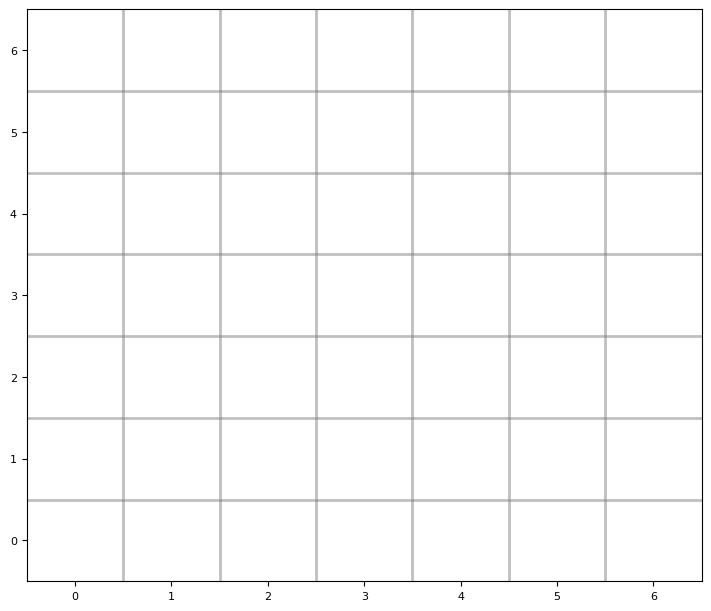

In [6]:
# to_remove solution

fig, ax = makeGrid(7, 7)
plt.show()

Bonus activity: Tweak the makeGrid function in the Plotting Functions cell above to make the gridlines green.

Wow, what a boring environment. Let's add an organism and something for that organism to interact with. We'll start with 10 food items scattered randomly throughout the grid, never more than one food item per cell. To plot these food item we need to initalize their locations by randomly sampling grid coordinates [without replacement](## "never picking the same (x,y) coordinate pair twice"). We'll place the agent roughly in the middle of the grid.

In [7]:
################################################################################
# TODO for students: replace ... in initLoc(...) to initialize the right number of 
# food item locations, in coordinates that make sense for our grid environment
# then comment out or remove the next line.
raise NotImplementedError("Exercise: make the grid the right size")
################################################################################
def initLoc(xSize, ySize, num):
  """Returns random 2d grid locations, without replacement, 
  in both unravled/flat coordinates and as xy pairs"""
  intLoc = np.random.choice(xSize * ySize, num, replace=False)
  xyLoc = np.vstack(np.unravel_index(intLoc, (xSize, ySize))).T
  return intLoc, xyLoc

fig, ax = makeGrid(7, 7)
initLoc(...)
plotFood(fig, ax, xyFoodLoc)
 
xyCritterLoc = (5,5)
plotCritter(fig, ax, xyCritterLoc)

fig.legend(loc='outside right upper')
plt.show()

NotImplementedError: Exercise: make the grid the right size

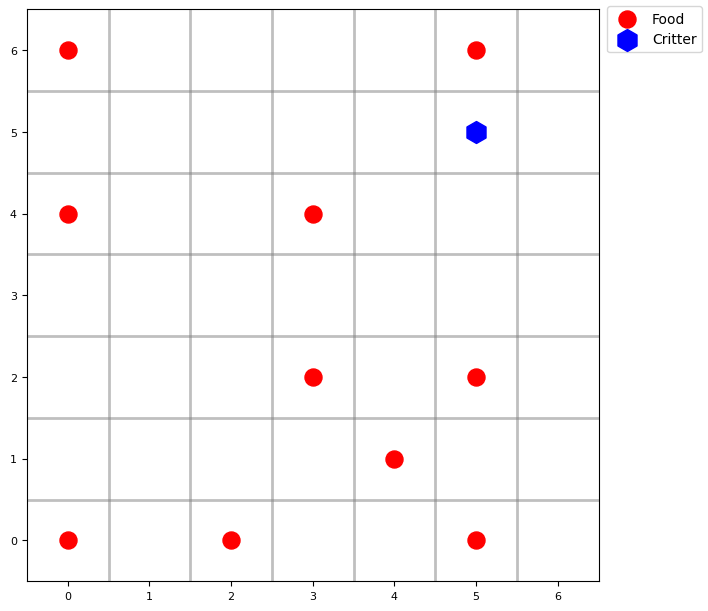

In [8]:
#to_remove solution
def initLoc(xSize, ySize, num):
  """Returns random 2d grid locations, without replacement, 
  in both unravled/flat coordinates and as xy pairs"""
  intLoc = np.random.choice(xSize * ySize, num, replace=False)
  xyLoc = np.vstack(np.unravel_index(intLoc, (xSize, ySize))).T
  return intLoc, xyLoc

fig, ax = makeGrid(7, 7)
intFoodLoc, xyFoodLoc = initLoc(7,7,10)
plotFood(fig, ax, xyFoodLoc)
 
xyCritterLoc = (5,5)
plotCritter(fig, ax, xyCritterLoc)

fig.legend(loc='outside right upper')
plt.show() 

In [9]:
# @markdown Vibe Check
content_review("Sequence 1.1.1 Micro 1")

---
# Micro 1.1.1.2: Random Eating

Now that we have an environment scattered with food and an organism, let's introduce some behaviour. The organism drifts around the environment randomly (connect to real life situations where this strategy is employed) and eats the food that they happen to stumble upon. When food is eaten, the organism gets a **reward**, in this case a *Food Eaten* point, and a new food item appears randomly somewhere else in the environment (that doesn't already have food). Run the following cell to see what this looks like.

Moved right. Criter is now at (6, 2).
No food here
Moves: 20 	Food Eaten: 1 	Food Per Move: 0.05


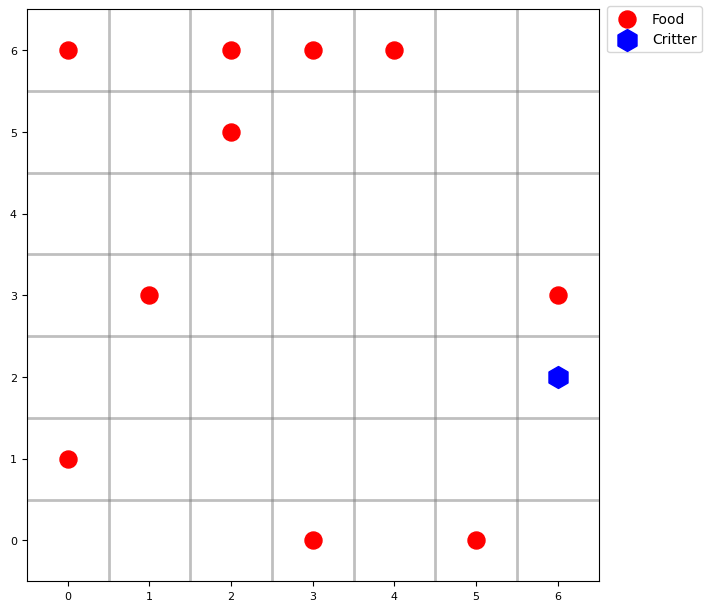

In [10]:
# @title Random Movement
# @markdown You don't need to worry about how this code works, yet – just **run the cell** for now and watch what happens
display(output)

# 20 random button presses, one every ~3 seconds
state = initState(xSize=7, ySize=7, numFoods=10)
for ii in range(20):
  randomClick()
  time.sleep(0.1)

When the organism is just drifting around randomly how good is it at eating lots of food, what is its efficiency in terms of food per movement? Now run the cell above a few more times. Does the organism always eat the same amount of food or does it change between simulation runs? 

In [11]:
# to_remove explanation

"""
The amount of food eaten vary a lot from simulation run to simulation run, 
usually it manages to eat one or two pieces of food, sometimes more sometimes less.
""";

Before we move on it's important to test that our simulation is running as we expect. The randomness of the environment can make this hard to test, but can overcome in part by setting up the environment in such a way that the outcome become deterministic. In the two cells bellow change how the the Grid World is initialized in terms of size, shape and number of food items. In one case so that organism is gaurenteed achieve 100% efficnency in terms of food per move and another case where the organism is gaurentted to achieve 0% efficiency.

In [12]:
###############################################################################
# TODO for students: replace ... in initState(...) to initialize a grid world 
# where the organism is always 100% efficient.
raise NotImplementedError("Exercise: make random movement 100% efficient")
################################################################################

display(output)

# 20 random moves, one every ~0.1 seconds
state = initState(...)
for ii in range(20):
  randomClick()
  time.sleep(0.1)

NotImplementedError: Exercise: make random movement 100% efficient

Moved right. Criter is now at (1, 1).
You ate the food here, new food at (2, 1)
Moves: 20 	Food Eaten: 20 	Food Per Move: 1.0


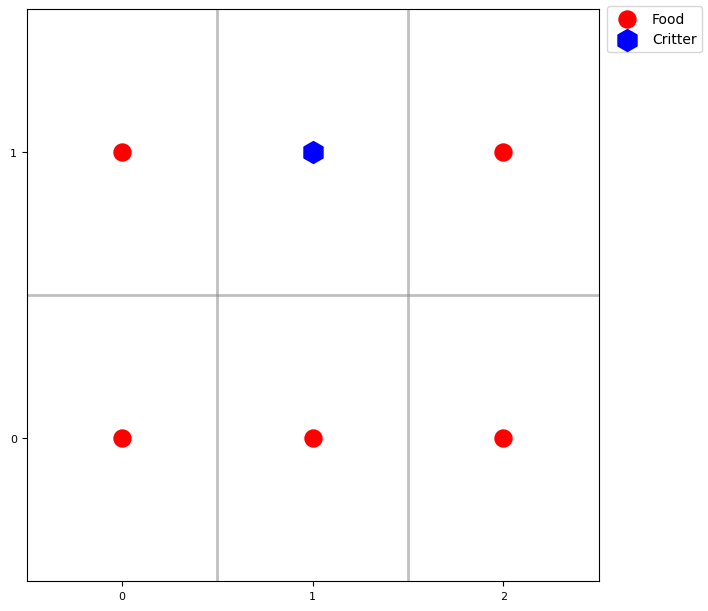

In [13]:
display(output)

# 20 random button presses, one every ~0.1 seconds
state = initState(xSize=3, ySize=2, numFoods=5)
for ii in range(20):
  randomClick()
  time.sleep(0.1)

In [14]:
###############################################################################
# TODO for students: replace ... in initState(...) to initialize a grid world 
# where the organism is always 0% efficient.
raise NotImplementedError("Exercise: make random movement 0% efficient")
################################################################################

display(output)

# 20 random button presses, one every ~0.1 seconds
state = initState(...)
for ii in range(20):
  randomClick()
  time.sleep(0.1)

NotImplementedError: Exercise: make random movement 0% efficient

Moved right. Criter is now at (3, 3).
No food here
Moves: 20 	Food Eaten: 2 	Food Per Move: 0.1


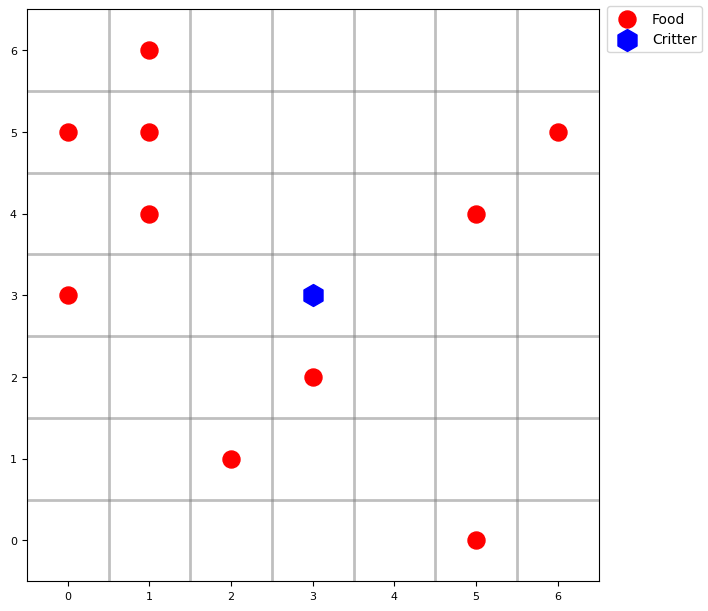

In [15]:
display(output)

# 20 random button presses, one every ~0.1 seconds
state = initState(xSize=7, ySize=7, numFoods=10)
for ii in range(20):
  randomClick()
  time.sleep(0.1)

---
# Micro 1.1.1.3: Better Than Random Eating
Now it's your turn to control the organism. Run the next cell and see how much more efficient than random drifting your control of the organism in terms of food per movement.

Press a button


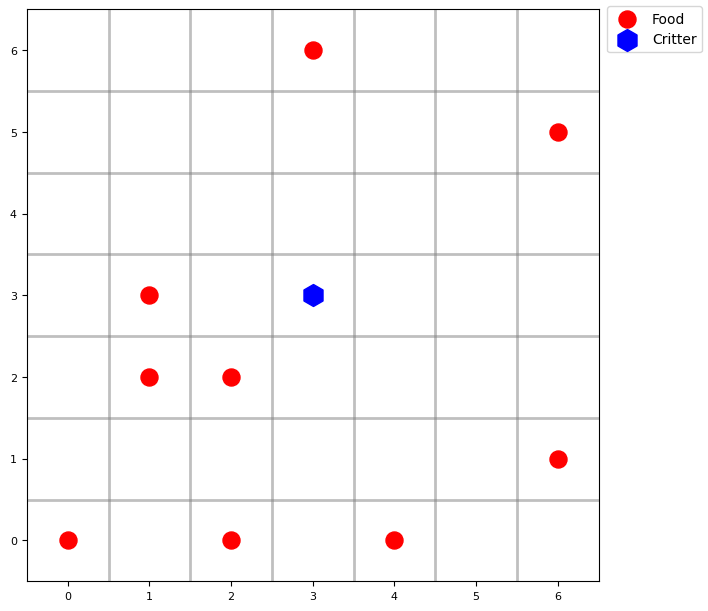

Output()

In [16]:
# @title Controlled Movement
# @markdown You don't need to worry about how this code works – just **run the cell** and then use the buttons to guide the organism

# user in control
state = initState()
with output:
  output.clear_output(wait=True)
  print('Press a button')
  plotFigFromScratch()
display(widgets.HBox([leftButton, widgets.VBox([upButton, downButton]), rightButton]), output)

Hopefully you were able to perform much better than a policy of random flailing. Even in this relatively simple, contrived and constrained foraging problem intellegence helps a lot. What kinds of strategies and heuristics did you use to guide your choice of direction? In some very real sense, the whole purpose of a nervous system and a brain is to solve problems of this kind, i.e., based on inputs from the environment which actions should be taken maximize reward.

---
# Micro 1.1.1.4: Optimal Eating
Finally we'd like to introduce a time traveling super organism, GW7x7-10-20, from the last chapter of this book. GW7x7-10-20 has absolutely mastered 7x7 grdiworld, with 10 food items and 20 round duration. Run the next cell and see how efficient a highly optimized and specialized gridworld organism can be. Are you as good as gw7x7-10-20? If not, you gotta read this book 😉 (If you can't beat 'em, at least learn how to program 'em.)

(Last chapter not made yet so working on a minimal sketch/skeleton version to produce this agent)

Press a button


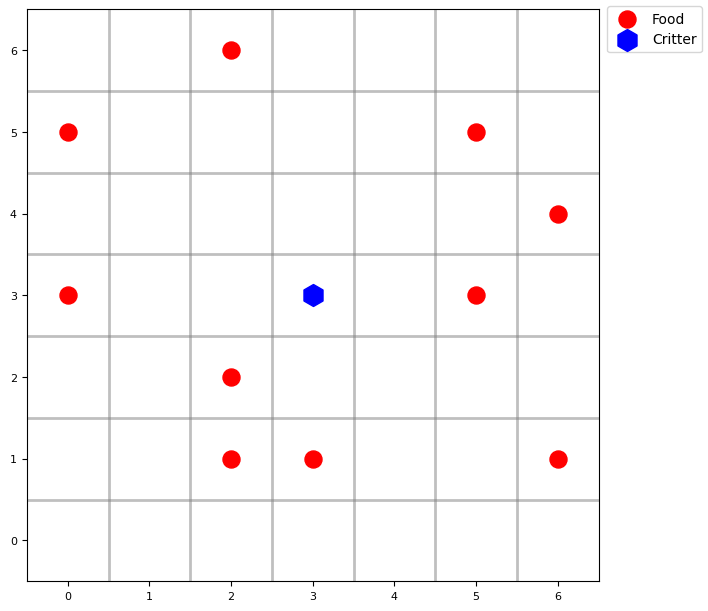

Output()

In [17]:
# @title Optimal Movement
# @markdown You don't need to worry about how this code works – just **run the cell** and then use the buttons to guide the organism

# user in control
state = initState()
with output:
  output.clear_output(wait=True)
  print('Press a button')
  plotFigFromScratch()
display(widgets.HBox([leftButton, widgets.VBox([upButton, downButton]), rightButton]), output)

---
# Graveyard


Press a button


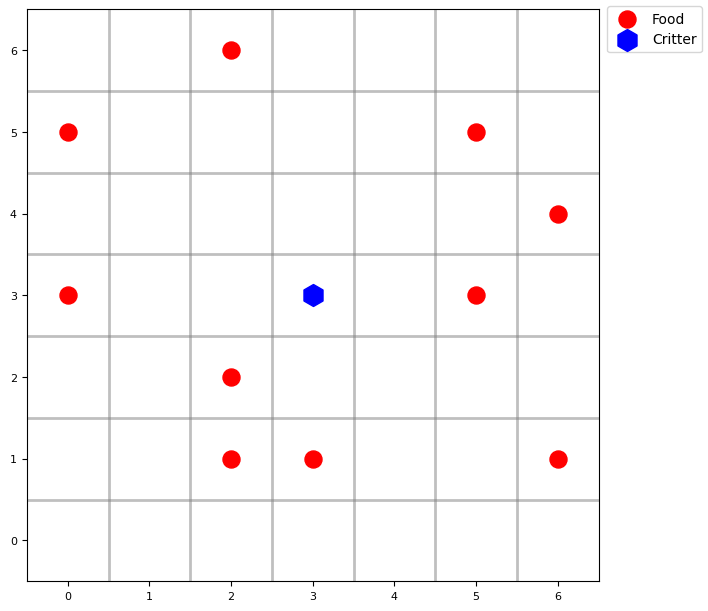

Checkbox(value=False, description='Move Randomly', indent=False)

Output()

In [18]:
%gui asyncio
with output:
  print('Press a button')
  plotFigFromScratch()
display(widgets.HBox([leftButton, widgets.VBox([upButton, downButton]), rightButton]), randomMovement, output)


Moved up. Criter is now at (3, 4).
No food here
Moves: 1 	Food Eaten: 0 	Food Per Move: 0.0


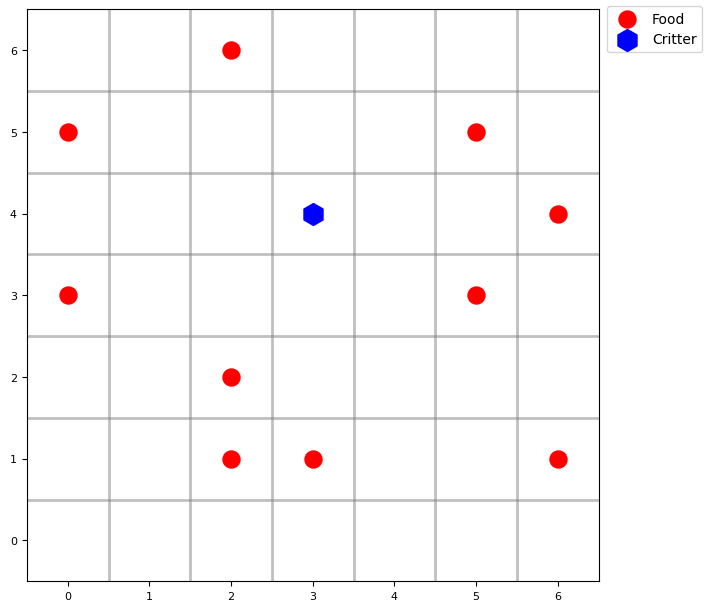

In [19]:
randomClick()

Press a button


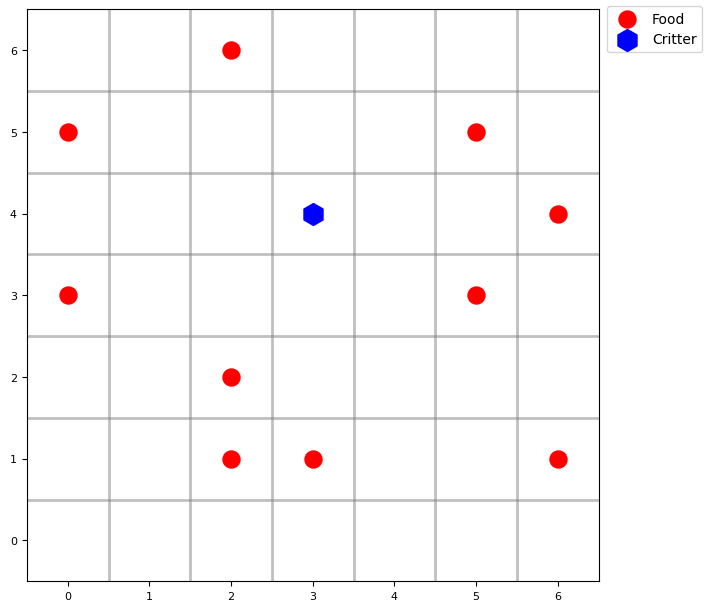

Button(description='Up', style=ButtonStyle())

Button(description='Down', style=ButtonStyle())

Button(description='Left', style=ButtonStyle())

Button(description='Right', style=ButtonStyle())

Output()

In [20]:
with output:
  output.clear_output(wait=True)
  print('Press a button')
  clickTimer.start()
  plotFigFromScratch()
display(upButton, downButton, leftButton, rightButton, output)

Press a button


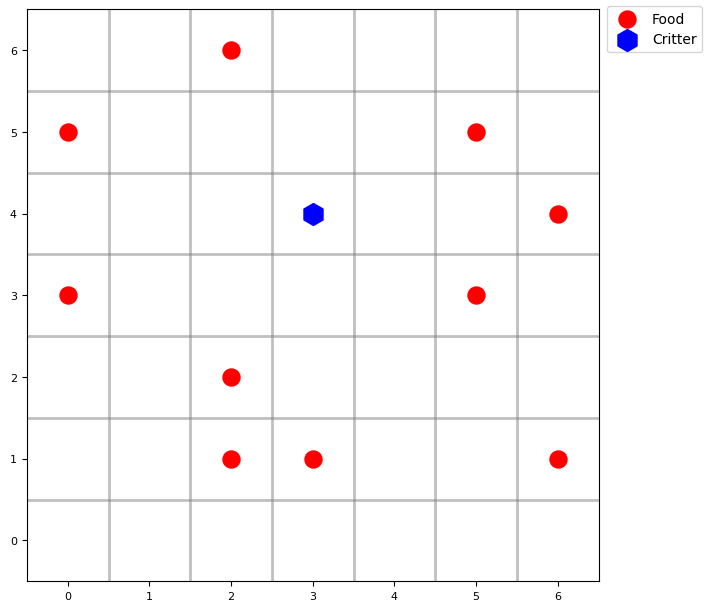

In [21]:
# user in control
with output:
  output.clear_output(wait=True)
  print('Press a button')  
  plotFigFromScratch()


Press a button


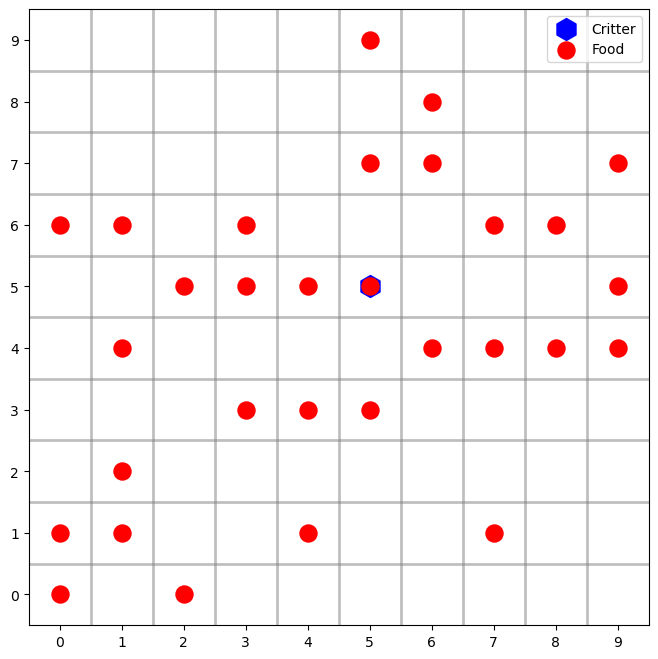

Button(description='Up', style=ButtonStyle())

Button(description='Down', style=ButtonStyle())

Button(description='Left', style=ButtonStyle())

Button(description='Right', style=ButtonStyle())

Output()

In [22]:
# user in control
state
stateDict = {'critterLocationXY': np.array([[]]),
             'critterLocationUnravel': np.array([]),
             'numMoves': 0,
             'numEats': 0,
             'numFoods': 30,
             'foodLocationsXY': np.array([[]]),
             'foodLocationsUnravel': np.array([]),
             'xSize': 10,
             'ySize': 10}

#randomly initialize food locations
stateDict['foodLocationsUnravel'] = np.sort(np.random.choice(stateDict['xSize']*stateDict['ySize'], stateDict['numFoods'], replace=False))
stateDict['foodLocationsXY'] = np.vstack(np.unravel_index(stateDict['foodLocationsUnravel'], (stateDict['xSize'], stateDict['ySize']))).T

# put critter roughly in the middle
stateDict['critterLocationXY'] = np.array([[np.floor(stateDict['xSize']/2), np.floor(stateDict['ySize']/2)]], dtype=int)
stateDict['critterLocationUravel'] = np.ravel_multi_index((stateDict['critterLocationXY'][:,0],stateDict['critterLocationXY'][:,1]), (stateDict['xSize'], stateDict['ySize'])) 

def updateCritterLocation(x, y, stateDict):
  stateDict['numMoves'] = stateDict['numMoves'] + 1
  stateDict['critterLocationXY'] = np.array([[x,y]])
  stateDict['critterLocationUravel'] = np.ravel_multi_index((stateDict['critterLocationXY'][:,0],stateDict['critterLocationXY'][:,1]), (stateDict['xSize'], stateDict['ySize']))
  return

def eating(stateDict):
  # is the critter on a food patch
  if stateDict['critterLocationUravel'][0] in set(stateDict['foodLocationsUnravel']):
    #print('eating!!!')
    #critter is on a food patch
    stateDict['numEats'] = stateDict['numEats'] + 1
    # add food where there isn't already food
    newFoodLocation = np.random.choice(list(set(np.arange(stateDict['xSize']*stateDict['ySize'])) - set(stateDict['foodLocationsUnravel'])))
    #print('new food location')
    #print(newFoodLocation)
    #old food gone
    #print('critter eating here')
    #print(stateDict['critterLocationUravel'][0])
    newFoodLocationsSet = set(stateDict['foodLocationsUnravel'])
    #print(np.array(np.sort(list(newFoodLocationsSet))))
    newFoodLocationsSet.remove(stateDict['critterLocationUravel'][0])
    #print(np.array(np.sort(list(newFoodLocationsSet))))

    # new food added
    newFoodLocationsSet.add(newFoodLocation)
    #print(np.array(np.sort(list(newFoodLocationsSet))))
    stateDict['foodLocationsUnravel'] = np.array(np.sort(list(newFoodLocationsSet)))
    stateDict['foodLocationsXY'] = np.vstack(np.unravel_index(stateDict['foodLocationsUnravel'], (stateDict['xSize'], stateDict['ySize']))).T
    #print(stateDict['foodLocationsUnravel'])
    stateDict['eatingString'] = ('You ate the food here, new food at ' + str(np.unravel_index(newFoodLocation, (stateDict['xSize'], stateDict['ySize']))))
  else:
    stateDict['eatingString'] = 'No food here'
  return

def updateState(x, y, StateDict):
  updateCritterLocation(x, y, StateDict)
  eating(stateDict)
  #print(stateDict['foodLocationsUnravel'])
  return

def plotFigFromScratch(stateDict):
  fig, ax = plt.subplots(figsize = (8,8))
  ax.set_xticks(np.arange(0, stateDict['xSize'], 1))
  ax.set_yticks(np.arange(0, stateDict['ySize'], 1))
  # Labels for major ticks
  ax.set_xticklabels(np.arange(0, stateDict['xSize'], 1))
  ax.set_yticklabels(np.arange(0, stateDict['ySize'], 1))

  # Minor ticks
  ax.set_xticks(np.arange(0.5, stateDict['xSize']-0.5, 1), minor=True)
  ax.set_yticks(np.arange(0.5, stateDict['ySize']-0.5, 1), minor=True)

  # Gridlines based on minor ticks
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)

  # Remove minor ticks
  ax.tick_params(which='minor', bottom=False, left=False)

  ax.set_xlim(( -0.5, stateDict['xSize']-0.5))
  ax.set_ylim(( -0.5, stateDict['ySize']-0.5))

  #ax.axis("equal")
  critter = ax.scatter([], [], s=250.0, marker='h', color='blue', label='Critter')
  food = ax.scatter([], [], s=150, marker='o', color='red', label='Food')
  critter.set_offsets(stateDict['critterLocationXY'])
  food.set_offsets(stateDict['foodLocationsXY'])
  ax.legend()
  plt.show()
  return

def buttonOutputUpdate(whichButton, x, y, stateDict):
  with output:
    output.clear_output(wait=True)
    print(whichButton + " Button clicked." + "Criter is now at ({}, {}).".format(x,y))
    print(stateDict['eatingString'])
    print("Moves: {0} \tFood Eaten: {1} \tFood Per Move: {2}".format(stateDict['numMoves'], stateDict['numEats'], stateDict['numEats'] / stateDict['numMoves']))
    plotFigFromScratch(stateDict)
  return

upButton = widgets.Button(description="Up")
downButton = widgets.Button(description="Down")
leftButton = widgets.Button(description="Left")
rightButton = widgets.Button(description="Right")
output = widgets.Output()

def on_upButton_clicked(b):
  whichButton = 'Up'
  x = stateDict['critterLocationXY'][0][0]
  y = stateDict['critterLocationXY'][0][1]
  if y >= stateDict['ySize']-1:
    y = stateDict['ySize'] - 2
  elif y < stateDict['ySize']-1:
    y = y+1
  updateState(x, y, stateDict)
  buttonOutputUpdate(whichButton, x, y, stateDict)

def on_downButton_clicked(b):
  whichButton = 'Down'
  x = stateDict['critterLocationXY'][0][0]
  y = stateDict['critterLocationXY'][0][1]
  if y > 0 :
    y = y-1
  elif y <= 0:
    y = 1
  updateState(x, y, stateDict)
  buttonOutputUpdate(whichButton, x, y, stateDict)

def on_leftButton_clicked(b):
  whichButton = 'Left'
  x = stateDict['critterLocationXY'][0][0]
  y = stateDict['critterLocationXY'][0][1]
  if x > 0 :
    x = x-1
  elif x <= 0:
    x = 1
  updateState(x, y, stateDict)
  buttonOutputUpdate(whichButton, x, y, stateDict)
    
def on_rightButton_clicked(b):
  whichButton = 'Right'
  x = stateDict['critterLocationXY'][0][0]
  y = stateDict['critterLocationXY'][0][1]
  if x >= stateDict['xSize']-1:
    x = stateDict['xSize'] - 2
  elif x < stateDict['xSize']-1:
    x = x+1
  updateState(x, y, stateDict)
  buttonOutputUpdate(whichButton, x, y, stateDict)

upButton.on_click(on_upButton_clicked)
downButton.on_click(on_downButton_clicked)
leftButton.on_click(on_leftButton_clicked)
rightButton.on_click(on_rightButton_clicked)

with output:
  output.clear_output(wait=True)
  print('Press a button')  
  plotFigFromScratch(stateDict)
display(upButton, downButton, leftButton, rightButton, output)

Left Button clicked.Criter is now at (3, 5).
No food here
Moves: 20 	Food Eaten: 5 	Food Per Move: 0.25


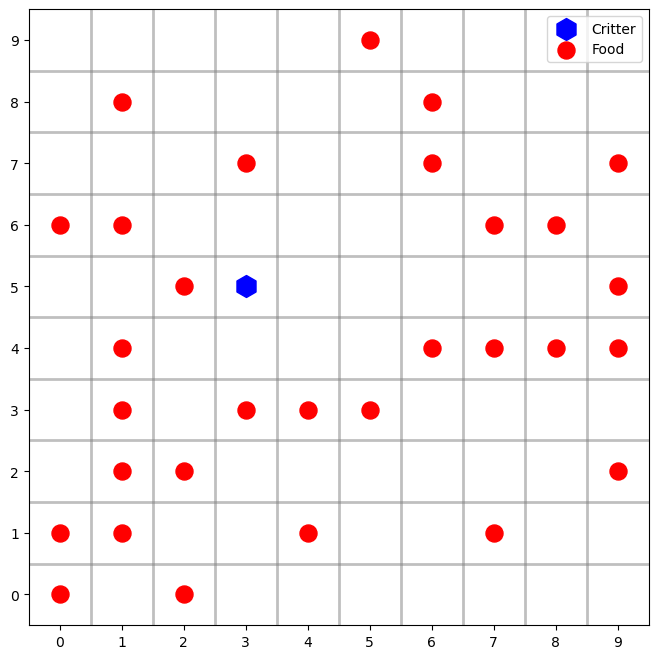

In [23]:
display(output)

# 20 random button presses one every ~0.1 seconds
for ii in range(20):
  move = np.random.randint(0,4)
  if move == 0:
    upButton.click()
  elif move == 1:
    downButton.click()
  elif move == 2:
    leftButton.click()
  elif move == 3:
    rightButton.click()
  else:
    print('should not happen')
  time.sleep(0.1)

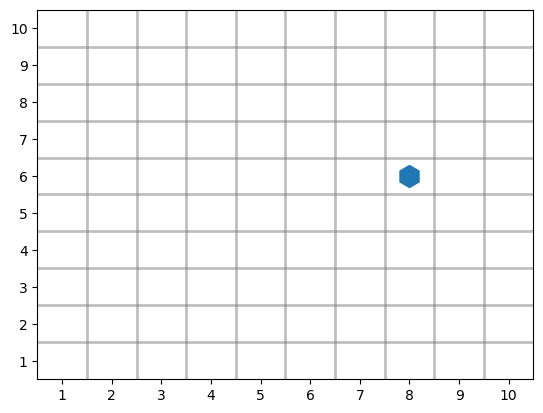

Right Button clicked.
New coordinate value is (8.0,6.0).


In [24]:
# janky random button pressing
stateDict = {'critterLocation': {'x': 5.0, 'y': 5.0},
              'numMoves': 0,
              'numEats': 0,
              'numFoods': 3,
              'foodLocation': np.array([[]]),
              'xSize': 10,
              'ySize': 10}

def sampleComb(dims, nsamp):
    idx = np.random.choice(np.prod(dims), nsamp, replace=False)
    return np.vstack(np.unravel_index(idx, dims)).T

stateDict['foodLocations'] = sampleComb([stateDict['xSize'], stateDict['ySize']], stateDict['numFoods'])

def plot_fig_from_scratch(stateDict):
  critterX = stateDict['critterLocation']['x']
  critterY = stateDict['critterLocation']['y'] 
  fig, ax = plt.subplots()
  ax.set_xticks(np.arange(0, stateDict['xSize']+1, 1))
  ax.set_yticks(np.arange(0, stateDict['ySize']+1, 1))
  # Labels for major ticks
  ax.set_xticklabels(np.arange(0, stateDict['xSize']+1, 1))
  ax.set_yticklabels(np.arange(0, stateDict['ySize']+1, 1))

  # Minor ticks
  ax.set_xticks(np.arange(1.5, stateDict['xSize']+0.5, 1), minor=True)
  ax.set_yticks(np.arange(1.5, stateDict['ySize']+0.5, 1), minor=True)

  # Gridlines based on minor ticks
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)

  # Remove minor ticks
  ax.tick_params(which='minor', bottom=False, left=False)

  ax.set_xlim(( 0.5, stateDict['xSize']+0.5))
  ax.set_ylim(( 0.5, stateDict['ySize']+0.5))

  #ax.axis("equal")
  critter = ax.scatter([], [], s=250.0, marker='h',)
  critter.set_offsets([[critterX, critterY]])
  plt.show()

upButton = widgets.Button(description="Up")
downButton = widgets.Button(description="Down")
leftButton = widgets.Button(description="Left")
rightButton = widgets.Button(description="Right")
output = widgets.Output()

def on_upButton_clicked(b):
  x = stateDict['critterLocation']['x']
  y = stateDict['critterLocation']['y']
  if y > 9:
    y = 9.0
  elif y <= 9:
    y = y+1
  stateDict['critterLocation']['y'] = y
  with output:
    output.clear_output(wait=True)
    plot_fig_from_scratch(stateDict)
    print("Up Button clicked.")
    print("New coordinate value is ({},{}).".format(x,y))

def on_downButton_clicked(b):
  x = stateDict['critterLocation']['x']
  y = stateDict['critterLocation']['y']
  if y > 1 :
    y = y-1
  elif y <= 1:
    y = 2.0
  stateDict['critterLocation']['y'] = y
  with output:
    output.clear_output(wait=True)
    plot_fig_from_scratch(stateDict)
    print("Down Button clicked.")
    print("New coordinate value is ({},{}).".format(x,y))

def on_leftButton_clicked(b):
  x = stateDict['critterLocation']['x']
  y = stateDict['critterLocation']['y']
  if x > 1 :
    x = x-1
  elif x <= 1:
    x = 2.0
  stateDict['critterLocation']['x'] = x
  with output:
    output.clear_output(wait=True)
    plot_fig_from_scratch(stateDict)
    print("Left Button clicked.")
    print("New coordinate value is ({},{}).".format(x,y))
    
def on_rightButton_clicked(b):
  x = stateDict['critterLocation']['x']
  y = stateDict['critterLocation']['y']
  if x < 10.0 :
    x = x+1
  elif x >= 10.0:
    x = 9.0
  stateDict['critterLocation']['x'] = x
  with output:
    output.clear_output(wait=True)
    plot_fig_from_scratch(stateDict)
    print("Right Button clicked.")
    print("New coordinate value is ({},{}).".format(x,y))

upButton.on_click(on_upButton_clicked)
downButton.on_click(on_downButton_clicked)
leftButton.on_click(on_leftButton_clicked)
rightButton.on_click(on_rightButton_clicked)


display(upButton, downButton, leftButton, rightButton, output)

# 20 random button presses one every ~0.1 seconds
for ii in range(20):
  move = np.random.randint(0,4)
  if move == 0:
    upButton.click()
  elif move == 1:
    downButton.click()
  elif move == 2:
    leftButton.click()
  elif move == 3:
    rightButton.click()
  else:
    print('should not happen')
  time.sleep(0.1)

#need to figure out how to overlay/interleave user button mashing and timed random button mashing

Useful scavenging from github and SO

In [25]:
# @title Simulation Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell** to start the simulation
# keep track of all relevant states of the simluation in a global state dictionary

def initState(xSize=10,
              ySize=10,
              numFoods=30,
              xyCritter=None):
  state = {'numMoves': 0,
           'numEats': 0,
           'numFoods': numFoods,
           'xyFoodLoc': np.array([[]]),
           'intFoodLoc': np.array([]),
           'xSize': xSize,
           'ySize': ySize}

  #randomly initialize food locations
  state['intFoodLoc'], state['xyFoodLoc'] = initLoc(state['xSize'],state['ySize'],state['numFoods'])

  if xyCritter is None:
    # put critter roughly in the middle
    state['xyCritterLoc'] = np.array([[np.floor(state['xSize']/2), np.floor(state['ySize']/2)]], dtype=int)
    state['intCritterLoc'] = np.ravel_multi_index((state['xyCritterLoc'][:,0],state['xyCritterLoc'][:,1]), (state['xSize'], state['ySize']))
  else:
    state['xyCritterLoc'] = np.array(xyCritter).reshape((1,2))
    state['intCritterLoc'] = np.ravel_multi_index((state['xyCritterLoc'][:,0],state['xyCritterLoc'][:,1]), (state['xSize'], state['ySize']))
  return state

state = initState()

def updateCritterLocation(x, y):
  state['numMoves'] = state['numMoves'] + 1
  state['xyCritterLoc'] = np.array([[x,y]])
  state['intCritterLoc'] = np.ravel_multi_index((state['xyCritterLoc'][:,0],state['xyCritterLoc'][:,1]), (state['xSize'], state['ySize']))

def eating():
  # is the critter on a food patch
  if state['intCritterLoc'][0] in set(state['intFoodLoc']):
    #critter is on a food patch
    state['numEats'] = state['numEats'] + 1
    # figure out where the new food will go where there isn't already food
    newFoodLoc = np.random.choice(list(set(np.arange(state['xSize']*state['ySize'])) - set(state['intFoodLoc'])))
    #remove the eaten food
    newFoodLocSet = set(state['intFoodLoc'])
    newFoodLocSet.remove(state['intCritterLoc'][0])
    # add the new food
    newFoodLocSet.add(newFoodLoc)
    
    #update state
    state['intFoodLoc'] = np.array(np.sort(list(newFoodLocSet)))
    state['xyFoodLoc'] = np.vstack(np.unravel_index(state['intFoodLoc'], (state['xSize'], state['ySize']))).T
    state['eatingString'] = ('You ate the food here, new food at ' + str(np.unravel_index(newFoodLoc, (state['xSize'], state['ySize']))))
  else:
    state['eatingString'] = 'No food here'

def updateState(x, y):
  updateCritterLocation(x, y)
  eating()
  #print(stateDict['foodLocationsUnravel'])

output = widgets.Output()

def plotFigFromScratch():
  fig, ax = makeGrid(state['xSize'], state['ySize'])
  plotFood(fig, ax, state['xyFoodLoc'])
  plotCritter(fig, ax, state['xyCritterLoc'])
  fig.legend(loc = "outside right upper")
  plt.show()

upButton = widgets.Button(description="Up")
downButton = widgets.Button(description="Down")
leftButton = widgets.Button(description="Left")
rightButton = widgets.Button(description="Right")
randomMovement = widgets.Checkbox(
    value=False,
    description='Move Randomly',
    disabled=False,
    indent=False
)

def randomClick():
  move = np.random.randint(0,4)
  if move == 0:
    upButton.click()
  elif move == 1:
    downButton.click()
  elif move == 2:
    leftButton.click()
  elif move == 3:
    rightButton.click()
  else:
    print('should not happen')


class Timer:
  def __init__(self, timeout, callback):
    self._timeout = timeout
    self._callback = callback
  async def _job(self):
    await asyncio.sleep(self._timeout)
    self._callback()
  def start(self):
    self._task = asyncio.ensure_future(self._job())
  def cancel(self):
    self._task.cancel()

clickTimer = Timer(5.0, randomClick)

def buttonOutputUpdate(whichButton, x, y):
  with output:
    if randomMovement.value == True:
      if hasattr(clickTimer, '__Task'):
        clickTimer.cancel()
    output.clear_output(wait=True)
    print("Moved " + whichButton + ". " + "Criter is now at ({}, {}).".format(x,y))
    print(state['eatingString'])
    print("Moves: {0} \tFood Eaten: {1} \tFood Per Move: {2}".format(state['numMoves'], state['numEats'], state['numEats'] / state['numMoves']))
    plotFigFromScratch()
    if randomMovement.value == True:
      clickTimer.start()

def on_upButton_clicked(b):
  whichButton = 'up'
  x = state['xyCritterLoc'][0][0]
  y = state['xyCritterLoc'][0][1]
  if y >= state['ySize']-1:
    y = state['ySize'] - 2
  elif y < state['ySize']-1:
    y = y+1
  updateState(x, y)
  buttonOutputUpdate(whichButton, x, y)

def on_downButton_clicked(b):
  whichButton = 'down'
  x = state['xyCritterLoc'][0][0]
  y = state['xyCritterLoc'][0][1]
  if y > 0 :
    y = y-1
  elif y <= 0:
    y = 1
  updateState(x, y)
  buttonOutputUpdate(whichButton, x, y)

def on_leftButton_clicked(b):
  whichButton = 'left'
  x = state['xyCritterLoc'][0][0]
  y = state['xyCritterLoc'][0][1]
  if x > 0 :
    x = x-1
  elif x <= 0:
    x = 1
  updateState(x, y)
  buttonOutputUpdate(whichButton, x, y)
    
def on_rightButton_clicked(b):
  whichButton = 'right'
  x = state['xyCritterLoc'][0][0]
  y = state['xyCritterLoc'][0][1]
  if x >= state['xSize']-1:
    x = state['xSize'] - 2
  elif x < state['xSize']-1:
    x = x+1
  updateState(x, y)
  buttonOutputUpdate(whichButton, x, y)

upButton.on_click(on_upButton_clicked)
downButton.on_click(on_downButton_clicked)
leftButton.on_click(on_leftButton_clicked)
rightButton.on_click(on_rightButton_clicked)

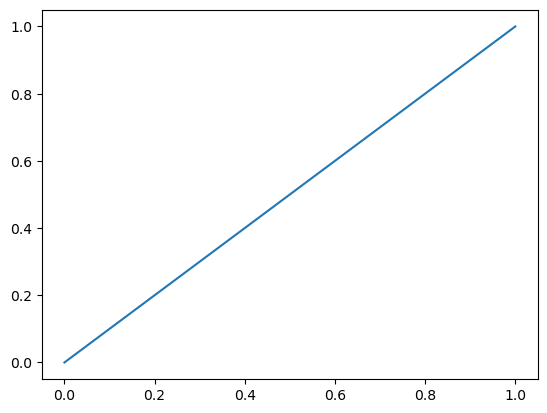

FloatSlider(value=1.0, max=2.0)

Output(layout=Layout(height='300px'))

In [26]:
out = widgets.Output(layout=widgets.Layout(height='300px'))

x = np.linspace(0,1,100)

def update_plot(w):
    with out:
        # Without clear_output(), figures get appended below each other inside
        # the output widget
        # Ah ha! Got it! I need wait=True!
        out.clear_output(wait=True)
        plt.plot(x, x**p_widget.value)  
        plt.show()

p_widget = widgets.FloatSlider(min=0, max=2, step=0.1, value = 1)
update_plot([])
p_widget.observe(update_plot)
display(p_widget, out)

In [27]:
import ipywidgets as widgets

x = 0
y = {"x": 0}
b = widgets.Button(description="Do it")

def doit(obj):
    print(x, y)
    # x += 1 # uncommenting makes the above print fail
    y["x"] += 1 # this is ok

b.on_click(doit)
display(b)

Button(description='Do it', style=ButtonStyle())

In [28]:
# how to get figures to work in this context nicely???
a = widgets.FloatSlider(description='a', min=0, max=10)
b = widgets.FloatSlider(description='b', min=0, max=10)
c = widgets.FloatSlider(description='c', min=0, max=10)

def f(a, b, c):
    print('{}*{}*{}={}'.format(a, b, c, a*b*c))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

widgets.HBox([widgets.VBox([a, b, c]), out])

0.0*0.0*0.0=0.0


In [29]:
from matplotlib import animation, rc, patches
from IPython.display import HTML

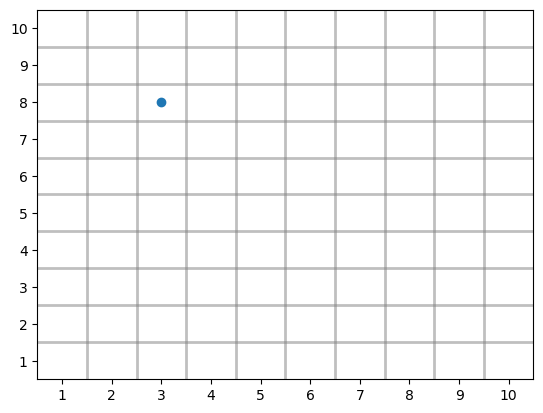

In [30]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xticks(np.arange(0, 11, 1))
ax.set_yticks(np.arange(0, 11, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(0, 11, 1))
ax.set_yticklabels(np.arange(0, 11, 1))

# Minor ticks
ax.set_xticks(np.arange(1.5, 10.5, 1), minor=True)
ax.set_yticks(np.arange(1.5, 10.5, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)

# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)

ax.set_xlim(( 0.5, 10.5))
ax.set_ylim(( 0.5, 10.5))

#ax.axis("equal")
scatter = ax.scatter([], [])
#critterCircle = plt.Circle((5,5), 0.4)
#dot = ax.add_patch(critterCircle)
#scatter.set_offsets([[5, 5]])

scatter.set_offsets([[3, 11-3]])
#fig.canvas.draw()
#fig.canvas.flush_events()

In [31]:
def init():
    scatter.set_offsets([[5, 5]])
    return scatter,

In [32]:
def animate_dot(i):
    print(i)
    x = i
    y = 11-i
    scatter.set_offsets([[x, y]])
    return scatter, 

In [33]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate_dot, init_func=init,
                               frames=(np.arange(10)+1), interval=500, blit=True)

In [34]:
# HTML(anim.to_html5_video())

In [35]:
# rc('animation', html='html5')

In [36]:
# anim

These movies are really pretty compared drawing everything from scratch, each time, need to figure out some way to combine the two eventually, but will keep prototyping in janky mode for now.

In [37]:
#widgets.__version__
#np.__version__

In [38]:
# gets the random movement to happen, but for whatever reason the random button clicks initiated by the asyncio don't automatically update the outputs...
# but they do get called since the state is updated, not sure what is going on there, but if I could figure it out this would be great
def buttonOutputUpdate(whichButton, x, y):
  with output:
    if randomMovement.value == True:
      if hasattr(clickTimer, '__Task'):
        clickTimer.cancel()
    output.clear_output(wait=True)
    print("Moved " + whichButton + ". " + "Criter is now at ({}, {}).".format(x,y))
    print(state['eatingString'])
    print("Moves: {0} \tFood Eaten: {1} \tFood Per Move: {2}".format(state['numMoves'], state['numEats'], state['numEats'] / state['numMoves']))
    plotFigFromScratch()
    if randomMovement.value == True:
      clickTimer.start()

In [39]:
np.array([[3, 7]], dtype=int).shape

(1, 2)

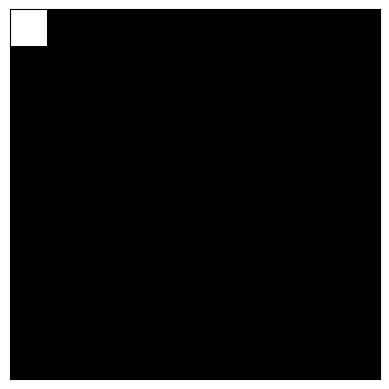

IntSlider(value=0, description='X', max=9)

IntSlider(value=0, description='Y', max=9)

In [40]:
# Define the grid dimensions
GRID_SIZE = 10

# Define the initial position of the circle
circle_x = 0
circle_y = 0

# Create a grid
grid = [[0] * GRID_SIZE for _ in range(GRID_SIZE)]

# Create a function to update the grid and plot the circle
def update_grid(x, y):
  global circle_x, circle_y
  grid[circle_y][circle_x] = 0  # Clear the previous circle position
  circle_x = max(0, min(x, GRID_SIZE - 1))  # Restrict x within grid boundaries
  circle_y = max(0, min(y, GRID_SIZE - 1))  # Restrict y within grid boundaries
  grid[circle_y][circle_x] = 1  # Set the new circle position
  plt.imshow(grid, cmap='gray', vmin=0, vmax=1)
  plt.xticks([])
  plt.yticks([])
  plt.show()

# Create the interactive widget
x_slider = widgets.IntSlider(min=0, max=GRID_SIZE - 1, value=circle_x, description='X')
y_slider = widgets.IntSlider(min=0, max=GRID_SIZE - 1, value=circle_y, description='Y')
widgets.interactive(update_grid, x=x_slider, y=y_slider)

# Display the widget
display(x_slider, y_slider)